In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

Using TensorFlow backend.


In [199]:
#!pip install imblearn

## Reading Dataset

In [5]:
data = pd.read_csv('train.csv')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  5279
Number of features :  4
Features :  ['unique_hash' 'text' 'drug' 'sentiment']


,unique_hash,text,drug,sentiment
0,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,Autoimmune diseases tend to come in clusters. ...,gilenya,2
1,9eba8f80e7e20f3a2f48685530748fbfa95943e4,I can completely understand why you’d want to ...,gilenya,2
2,fe809672251f6bd0d986e00380f48d047c7e7b76,Interesting that it only targets S1P-1/5 recep...,fingolimod,2
3,bd22104dfa9ec80db4099523e03fae7a52735eb6,"Very interesting, grand merci. Now I wonder wh...",ocrevus,2
4,b227688381f9b25e5b65109dd00f7f895e838249,"Hi everybody, My latest MRI results for Brain ...",gilenya,1


In [152]:
data_test = pd.read_csv('test.csv')
print('Number of data points : ', data_test.shape[0])
print('Number of features : ', data_test.shape[1])
print('Features : ', data_test.columns.values)
data_test.head()

Number of data points :  2924
Number of features :  3
Features :  ['unique_hash' 'text' 'drug']


,unique_hash,text,drug
0,9e9a8166b84114aca147bf409f6f956635034c08,"256 (previously stable on natalizumab), with 5...",fingolimod
1,e747e6822c867571afe7b907b51f0f2ca67b0e1a,On fingolimod and have been since December 201...,fingolimod
2,50b6d851bcff4f35afe354937949e9948975adf7,Apparently it's shingles! :-/ I do have a few ...,humira
3,7f82ec2176ae6ab0b5d20b5ffc767ac829f384ae,If the Docetaxel doing once a week x3 weeks th...,tagrisso
4,8b37d169dee5bdae27060949242fb54feb6a7f7f,"CC, Stelara worked in a matter of days for me....",stelara


## Preprocessing of text

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\IDM
[nltk_data]     LAB-09\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [153]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data[column][index] = string

In [10]:

#text processing stage.
start_time = time.clock()
for index, row in data.iterrows():
    if type(row['text']) is str:
        nlp_preprocessing(row['text'], index, 'text')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

Time took for preprocessing the text : 390.0765071840001 seconds


In [154]:
#text processing stage.
start_time = time.clock()
for index, row in data_test.iterrows():
    if type(row['text']) is str:
        nlp_preprocessing(row['text'], index, 'text')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

Time took for preprocessing the text : 238.2578997519995 seconds


In [162]:
data_test.head(5)

,unique_hash,text,drug
0,9e9a8166b84114aca147bf409f6f956635034c08,"256 (previously stable on natalizumab), with 5...",fingolimod
1,e747e6822c867571afe7b907b51f0f2ca67b0e1a,On fingolimod and have been since December 201...,fingolimod
2,50b6d851bcff4f35afe354937949e9948975adf7,Apparently it's shingles! :-/ I do have a few ...,humira
3,7f82ec2176ae6ab0b5d20b5ffc767ac829f384ae,If the Docetaxel doing once a week x3 weeks th...,tagrisso
4,8b37d169dee5bdae27060949242fb54feb6a7f7f,"CC, Stelara worked in a matter of days for me....",stelara


In [11]:
data.head(10)

,unique_hash,text,drug,sentiment
0,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,autoimmune diseases tend come clusters gilenya...,gilenya,2
1,9eba8f80e7e20f3a2f48685530748fbfa95943e4,completely understand want try results reporte...,gilenya,2
2,fe809672251f6bd0d986e00380f48d047c7e7b76,interesting targets s1p 1 5 receptors rather 1...,fingolimod,2
3,bd22104dfa9ec80db4099523e03fae7a52735eb6,interesting grand merci wonder lemtrada ocrevu...,ocrevus,2
4,b227688381f9b25e5b65109dd00f7f895e838249,hi everybody latest mri results brain cervical...,gilenya,1
5,a043780c757966243779bf3c0d11bf6eef721971,give advice lemtrada chose cladribine thought ...,cladribine,2
6,be5a13376933a7f9bbf8e801c31691092f63260a,reply posted jesszidek hi jess sorry read chal...,humira,0
7,08c3c0c702fc97d290204b37798ac62005da5626,well expected neurologist wants start tysabri ...,gilenya,2
8,8fd3d7ad80791c9343e5cf8a83bd1adf6577d516,think fingolimod miserable failure progressive...,fingolimod,1
9,793c5af7cc8332df17eb602247d886fbd1c80f89,thank much learning lot grace mentioned husban...,tagrisso,2


In [12]:
data[data.isnull().any(axis=1)]

,unique_hash,text,drug,sentiment


no missing value

## Test, Train and Cross Validation Split

#### Splitting data into train, test and cross validation (64:20:16)

In [161]:
data_test.drug  = data_test.drug.str.replace('\s+', '_')

In [13]:
y_true = data['sentiment'].values
data.drug  = data.drug.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)


We split the data into train, test and cross validation data sets, preserving the ratio of class distribution in the original data set

In [14]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 3378
Number of data points in test data: 1056
Number of data points in cross validation data: 845


In [15]:
train_class_distribution = train_df['sentiment'].value_counts()
type(train_class_distribution)

pandas.core.series.Series

#### Distribution of y_i's in Train, Test and Cross Validation datasets

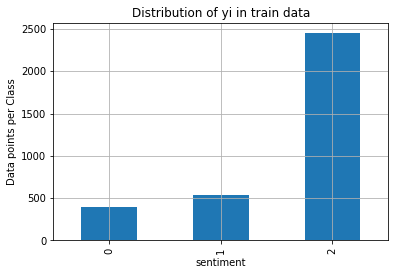

Number of data points in class 3 : 2448 ( 72.469 %)
Number of data points in class 2 : 535 ( 15.838 %)
Number of data points in class 1 : 395 ( 11.693 %)
--------------------------------------------------------------------------------


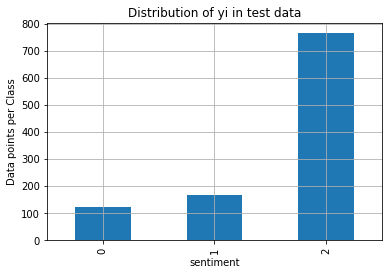

Number of data points in class 3 : 765 ( 72.443 %)
Number of data points in class 2 : 168 ( 15.909 %)
Number of data points in class 1 : 123 ( 11.648 %)
--------------------------------------------------------------------------------


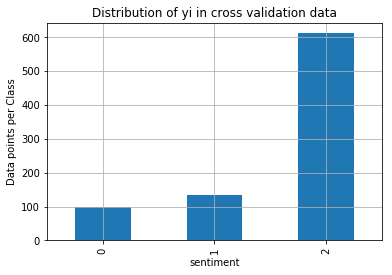

Number of data points in class 3 : 612 ( 72.426 %)
Number of data points in class 2 : 134 ( 15.858 %)
Number of data points in class 1 : 99 ( 11.716 %)


In [16]:
#cv_class_distribution = cv_df['Class'].value_counts().sortlevel()
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = train_df['sentiment'].value_counts().sort_index()
test_class_distribution = test_df['sentiment'].value_counts().sort_index()
cv_class_distribution = cv_df['sentiment'].value_counts().sort_index()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('sentiment')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('sentiment')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('sentiment')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')

Data are imbalance

all tran test and cv have almost same distribution(good for model)

## Univariate Analysis

Features :  ['unique_hash' 'text' 'drug' 'sentiment']


In [61]:


# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):

 
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(0,3):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['drug']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*30)/ (denominator + 70*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):

    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/3,1/3,1/3])
#             
    return gv_fea

In [62]:
print('Features : ', data.columns.values)

Features :  ['unique_hash' 'text' 'drug' 'sentiment']


In [63]:
unique_drug = train_df['drug'].value_counts()
print('Number of Unique drug :', unique_drug.shape[0])
# the top 10 genes that occured most
print(unique_drug.head(10))

Number of Unique drug : 89
ocrevus        425
gilenya        420
ocrelizumab    278
humira         180
entyvio        178
fingolimod     157
tarceva        155
remicade       151
opdivo         145
keytruda       133
Name: drug, dtype: int64


In [64]:
print("Ans: There are", unique_drug.shape[0] ,"different categories of drug in the train data, and they are distibuted as follows",)

Ans: There are 89 different categories of drug in the train data, and they are distibuted as follows


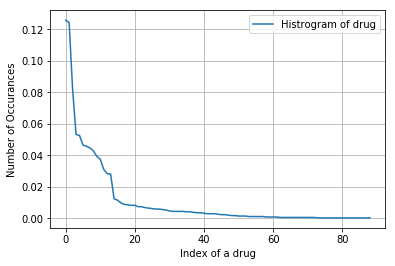

In [65]:

s = sum(unique_drug.values);
h = unique_drug.values/s;
plt.plot(h, label="Histrogram of drug")
plt.xlabel('Index of a drug')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

most of the drug occure very few time it is right skewed histogram plot very less variation of drug occure maximum times.

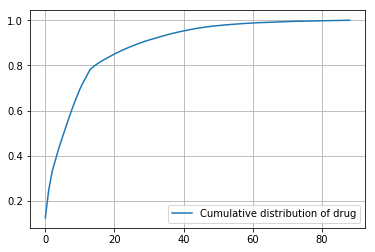

In [66]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of drug')
plt.grid()
plt.legend()
plt.show()

top 20 drug occupy 82% of data

### Featurization

there are two ways we can featurize this variable

One hot Encoding

Response coding

We will choose the appropriate featurization based on the ML model we use. For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression while response coding is better for Random Forests.

In [163]:
data_test_drug_feature_responseCoding = np.array(get_gv_feature(alpha, "drug", data_test))

In [160]:

#response-coding of the drug feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_drug_feature_responseCoding = np.array(get_gv_feature(alpha, "drug", train_df))
# test gene feature
test_drug_feature_responseCoding = np.array(get_gv_feature(alpha, "drug", test_df))
# cross validation gene feature
cv_drug_feature_responseCoding = np.array(get_gv_feature(alpha, "drug", cv_df))

In [46]:
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_drug_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (3378, 3)


In [47]:
# one-hot encoding of drug feature.
drug_vectorizer = CountVectorizer()
train_drug_feature_onehotCoding = drug_vectorizer.fit_transform(train_df['drug'])
test_drug_feature_onehotCoding = drug_vectorizer.transform(test_df['drug'])
cv_drug_feature_onehotCoding = drug_vectorizer.transform(cv_df['drug'])

In [191]:
data_test_drug_feature_onehotCoding = drug_vectorizer.transform(data_test['drug'])

In [48]:
train_df['drug'].head()

1266    fingolimod
4921       ocrevus
3741       gilenya
4936       tysabri
1489      afatinib
Name: drug, dtype: object

In [49]:

drug_vectorizer.get_feature_names()

['afatinib',
 'aflibercept',
 'alecensa',
 'alectinib',
 'alimta',
 'almita',
 'arzerra',
 'atezolizumab',
 'aubagio',
 'avastin',
 'bevacizumab',
 'brigatinib',
 'brolucizumab',
 'ceritinib',
 'certolizumab_pegol',
 'cimzia',
 'cladribine',
 'crizotinib',
 'ct',
 'cyltezo',
 'cyramza',
 'dabrafenib',
 'dexamethasone',
 'dexamethasone_implant',
 'durvalumab',
 'dyyb',
 'entrectinib',
 'entyvio',
 'erlotinib',
 'eylea',
 'filgotinib',
 'fingolimod',
 'gefitinib',
 'geftinib',
 'gilenya',
 'gilotrif',
 'golimumab',
 'guselkumab',
 'humira',
 'imfinzi',
 'inflectra',
 'infliximab',
 'ipilimumab',
 'iressa',
 'ixifi',
 'keytruda',
 'laser_photocoagulation',
 'lemtrada',
 'lucentis',
 'macugen',
 'mavenclad',
 'mekinist',
 'movectro',
 'necitumumab',
 'nivolumab',
 'ocrelizumab',
 'ocrevus',
 'ofatumumab',
 'opdivo',
 'osimertinib',
 'ozurdex',
 'p13',
 'pan',
 'panretinal_photocoagulation',
 'pegaptanib',
 'pembrolizumab',
 'pemetrexed',
 'pemrolizumab',
 'photodynamic_therapy',
 'ranibizu

In [50]:
print("train_drug_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_drug_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (3378, 92)


In [51]:

print("Q6. How many data points in Test and CV datasets are covered by the ", unique_drug.shape[0], " drugs in train dataset?")

test_coverage=test_df[test_df['drug'].isin(list(set(train_df['drug'])))].shape[0]
cv_coverage=cv_df[cv_df['drug'].isin(list(set(train_df['drug'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  89  drugs in train dataset?
Ans
1. In test data 1047 out of 1056 : 99.14772727272727
2. In cross validation data 838 out of  845 : 99.1715976331361


### Univariate Analysis on Text Feature

In [52]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['text'].split():
            dictionary[word] +=1
    return dictionary

In [111]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],3))
    for i in range(0,3):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['text'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+30 )/(total_dict.get(word,0)+70)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['text'].split()))
            row_index += 1
    return text_feature_responseCoding

In [68]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['text'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 13117


In [69]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(0,3):
    cls_text = train_df[train_df['sentiment']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,3):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [158]:
data_test_text_feature_responseCoding  = get_text_responsecoding(data_test)

In [112]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [71]:

# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['text'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['text'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [192]:
# we use the same vectorizer that was trained on train data
data_test_text_feature_onehotCoding = text_vectorizer.transform(data_test['text'])
# don't forget to normalize every feature
data_test_text_feature_onehotCoding = normalize(data_test_text_feature_onehotCoding, axis=0)

In [72]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [73]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 1552, 4: 1184, 5: 898, 6: 799, 7: 639, 8: 544, 9: 473, 10: 379, 11: 354, 13: 306, 12: 302, 14: 264, 16: 211, 15: 198, 17: 168, 18: 163, 19: 152, 21: 149, 20: 144, 22: 122, 23: 117, 24: 109, 25: 102, 27: 85, 30: 82, 29: 78, 28: 78, 31: 77, 32: 72, 33: 69, 26: 68, 35: 66, 43: 61, 34: 59, 38: 56, 39: 53, 37: 51, 40: 49, 36: 48, 42: 46, 44: 45, 41: 43, 46: 42, 59: 40, 45: 40, 63: 37, 67: 34, 52: 33, 50: 33, 49: 33, 55: 32, 47: 31, 62: 30, 53: 30, 60: 29, 56: 29, 51: 29, 58: 28, 54: 28, 80: 26, 70: 26, 64: 26, 48: 26, 57: 25, 81: 24, 77: 24, 69: 24, 61: 24, 74: 23, 72: 23, 85: 21, 73: 21, 113: 20, 101: 20, 78: 20, 66: 20, 99: 18, 95: 18, 76: 18, 75: 18, 71: 18, 94: 17, 68: 17, 93: 16, 87: 16, 79: 16, 102: 15, 89: 15, 65: 15, 115: 14, 112: 14, 103: 14, 97: 14, 92: 14, 90: 14, 84: 14, 83: 14, 129: 13, 108: 13, 98: 13, 88: 13, 134: 12, 124: 12, 119: 12, 118: 12, 104: 12, 135: 11, 105: 11, 150: 10, 137: 10, 100: 10, 91: 10, 86: 10, 218: 9, 149: 9, 144: 9, 121: 9, 117: 9, 82: 9, 167:

In [74]:

def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['text'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [75]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

97.158 % of word of test data appeared in train data
98.139 % of word of Cross Validation appeared in train data


## Machine Learning Models

In [101]:

#Data preparation for ML models.

#Misc. functionns for ML models


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating f1_score we willl provide the array of probabilities belongs to each class
    print("f1 score :",f1_score(test_y, sig_clf.predict(test_x),average='macro'))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [102]:
def report_f1_score(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict(test_x)
    return f1_score(test_y, sig_clf_probs,average='macro')

In [103]:

# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, drug, var, no_features):
    drug_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    drug_vec = drug_count_vec.fit(train_df['drug'])
    text_vec = text_count_vec.fit(train_df['text'])
    
    fea1_len = len(drug_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = drug_vec.get_feature_names()[v]
            yes_no = True if word == drug else False
            if yes_no:
                word_present += 1
                print(i, "drug feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

### Stacking the feature

In [113]:
'''
train_drug_var_onehotCoding = hstack((train_drug_feature_onehotCoding,train_variation_feature_onehotCoding))
test_drug_var_onehotCoding = hstack((test_drug_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_drug_var_onehotCoding = hstack((cv_drug_feature_onehotCoding,cv_variation_feature_onehotCoding))'''

train_x_onehotCoding = hstack((train_drug_feature_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['sentiment']))

test_x_onehotCoding = hstack((test_drug_feature_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['sentiment']))

cv_x_onehotCoding = hstack((cv_drug_feature_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['sentiment']))


'''train_drug_var_responseCoding = np.hstack((train_drug_feature_responseCoding,train_variation_feature_responseCoding))
test_drug_var_responseCoding = np.hstack((test_drug_feature_responseCoding,test_variation_feature_responseCoding))
cv_drug_var_responseCoding = np.hstack((cv_drug_feature_responseCoding,cv_variation_feature_responseCoding))'''

train_x_responseCoding = np.hstack((train_drug_feature_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_drug_feature_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_drug_feature_responseCoding, cv_text_feature_responseCoding))

In [193]:
data_test_x_onehotCoding = hstack((data_test_drug_feature_onehotCoding, data_test_text_feature_onehotCoding)).tocsr()

In [164]:
data_test_x_responseCoding = np.hstack((data_test_drug_feature_responseCoding, data_test_text_feature_responseCoding))

In [82]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (3378, 13209)
(number of data points * number of features) in test data =  (1056, 13209)
(number of data points * number of features) in cross validation data = (845, 13209)


In [114]:

print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (3378, 6)
(number of data points * number of features) in test data =  (1056, 6)
(number of data points * number of features) in cross validation data = (845, 6)


## Naive Bayes

In [104]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)

    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    
    labels = [0,1,2]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

#### Hyper parameter tuning

In [ ]:
from sklearn.metrics import f1_score

for alpha = 1e-05
f1_score : 0.2800274536719286
for alpha = 0.0001
f1_score : 0.27842866988283943
for alpha = 0.001
f1_score : 0.2780847145488029
for alpha = 0.1
f1_score : 0.2800274536719286
for alpha = 1
f1_score : 0.27922971114167816
for alpha = 10
f1_score : 0.2800274536719286
for alpha = 100
f1_score : 0.2800274536719286
for alpha = 1000
f1_score : 0.2800274536719286


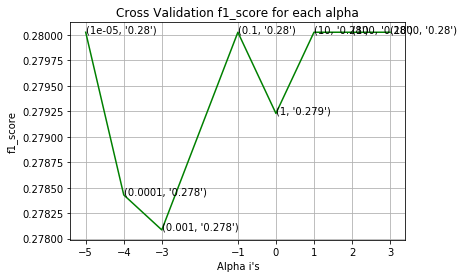

For values of best alpha =  1e-05 The train f1_score is: 0.2801235839340886
For values of best alpha =  1e-05 The cross validation f1_score is: 0.2800274536719286
For values of best alpha =  1e-05 The test f1_score is: 0.2800658978583196


In [105]:
# find more about Multinomial Naive base function here http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_f1_score_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict(cv_x_onehotCoding)
    cv_f1_score_array.append(f1_score(cv_y, sig_clf_probs,average='macro'))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("f1_score :",f1_score(cv_y, sig_clf_probs,average='macro')) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_f1_score_array,c='g')
for i, txt in enumerate(np.round(cv_f1_score_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_f1_score_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation f1_score for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("f1_score")
plt.show()


best_alpha = np.argmax(cv_f1_score_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train f1_score is:",f1_score(y_train, predict_y, labels=clf.classes_,average='macro'))
predict_y = sig_clf.predict(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation f1_score is:",f1_score(y_cv, predict_y, labels=clf.classes_,average='macro'))
predict_y = sig_clf.predict(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test f1_score is:",f1_score(y_test, predict_y, labels=clf.classes_,average='macro'))

#### Testing the model with best hyper paramters

f1_score : 0.2800274536719286
Number of missclassified point : 0.2757396449704142
-------------------- Confusion matrix --------------------


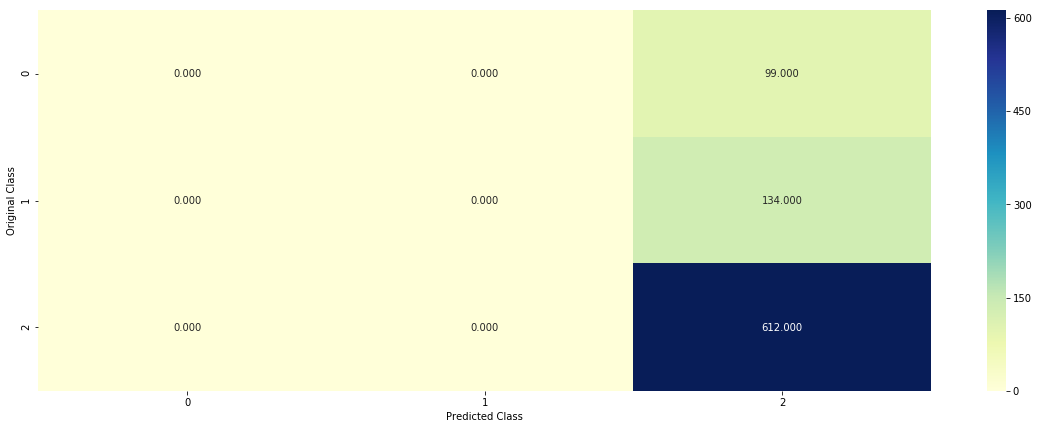

-------------------- Precision matrix (Columm Sum=1) --------------------


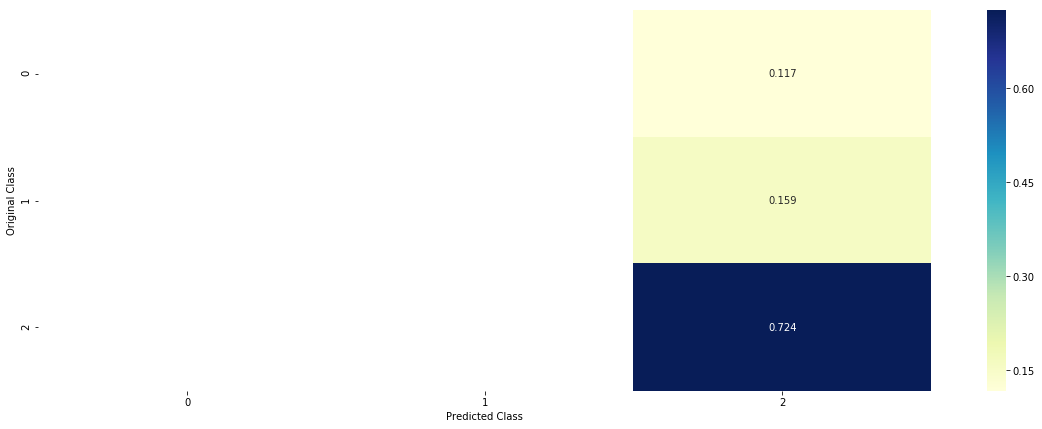

-------------------- Recall matrix (Row sum=1) --------------------


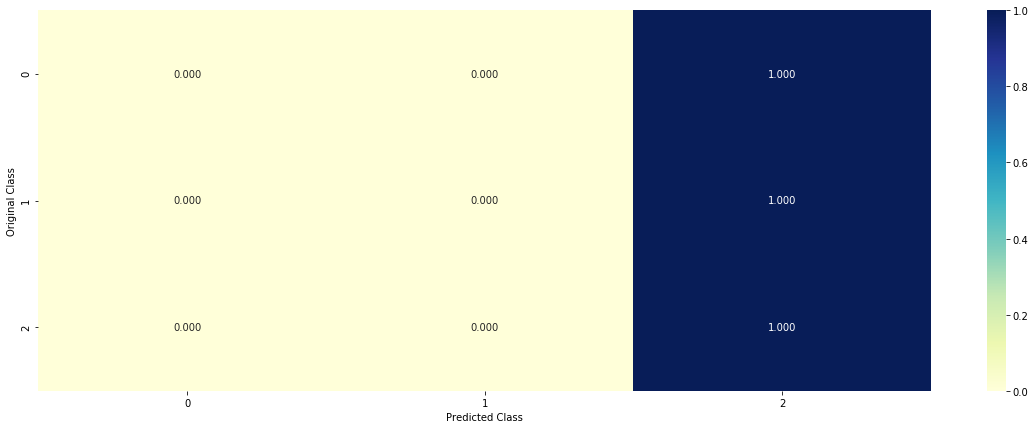

In [106]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("f1_score :",f1_score(cv_y, sig_clf_probs,average='macro'))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

#### Correctly classified point

In [108]:
from sklearn.feature_extraction.text import TfidfVectorizer
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
#get_impfeature_names(indices[0], test_df['text'].iloc[test_point_index],test_df['drug'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.1123 0.1361 0.7516]]
Actual Class : 1
--------------------------------------------------


### K Nearest Neighbour Classification

#### Hyper parameter tuning

for alpha = 5
f1_score : 0.31613435929868944
for alpha = 11
f1_score : 0.3395131681572732
for alpha = 15
f1_score : 0.3587975781020494
for alpha = 21
f1_score : 0.35236370317872795
for alpha = 31
f1_score : 0.3490567788141681
for alpha = 41
f1_score : 0.3567769741666271
for alpha = 51
f1_score : 0.355380683346785
for alpha = 99
f1_score : 0.35680800932682194


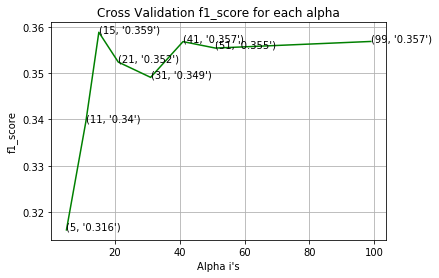

For values of best alpha =  15 The train f1_score is: 0.3946232496345659
For values of best alpha =  15 The cross validation f1_score is: 0.3587975781020494
For values of best alpha =  15 The test f1_score is: 0.33840919578228207


In [116]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_f1_score_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict(cv_x_responseCoding)
    cv_f1_score_array.append(f1_score(cv_y, sig_clf_probs,average='macro'))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("f1_score :",f1_score(cv_y, sig_clf_probs,average='macro'))  

fig, ax = plt.subplots()
ax.plot(alpha, cv_f1_score_array,c='g')
for i, txt in enumerate(np.round(cv_f1_score_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_f1_score_array[i]))
plt.grid()
plt.title("Cross Validation f1_score for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("f1_score")
plt.show()


best_alpha = np.argmax(cv_f1_score_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train f1_score is:",f1_score(y_train, predict_y,average='macro'))
predict_y = sig_clf.predict(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation f1_score is:",f1_score(y_cv, predict_y,average='macro'))
predict_y = sig_clf.predict(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test f1_score is:",f1_score(y_test, predict_y,average='macro'))

#### Testing the model with best hyper paramters

f1 score : 0.3587975781020494
Number of mis-classified points : 0.2781065088757396
-------------------- Confusion matrix --------------------


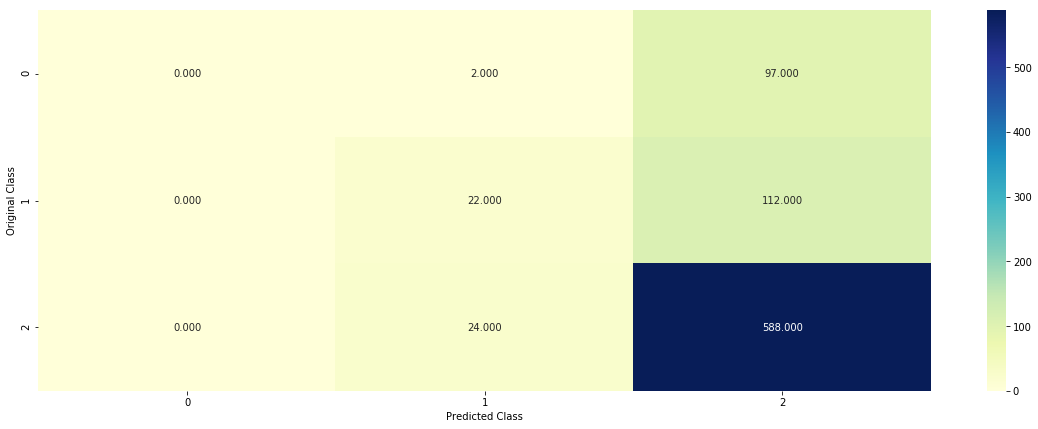

-------------------- Precision matrix (Columm Sum=1) --------------------


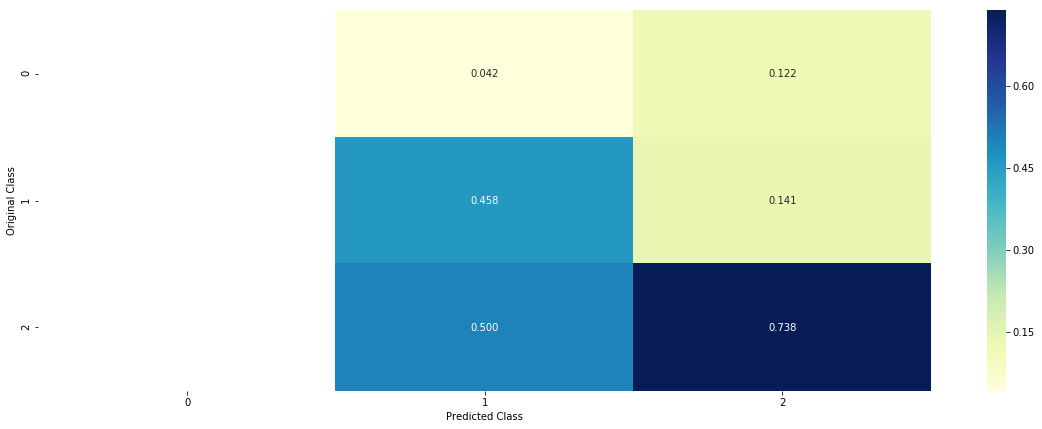

-------------------- Recall matrix (Row sum=1) --------------------


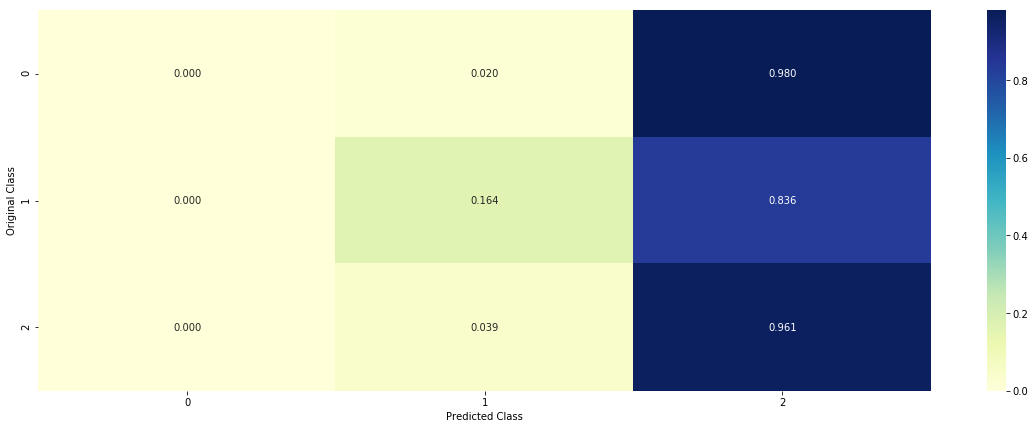

In [117]:
# find more about KNeighborsClassifier() here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.
#-------------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/k-nearest-neighbors-geometric-intuition-with-a-toy-example-1/
#-------------------------------------
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

In [118]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 2
Actual Class : 1
The  15  nearest neighbours of the test points belongs to classes [2 0 2 2 2 2 2 2 2 2 2 2 2 2 2]
Fequency of nearest points : Counter({2: 14, 0: 1})


## Logistic Regression  With Class balancing

### one hot encoding

#### Hyper paramter tuning

for alpha = 1e-06
f1_score : 0.2800274536719286
for alpha = 1e-05
f1_score : 0.28455439646315056
for alpha = 0.0001
f1_score : 0.29745730240387935
for alpha = 0.001
f1_score : 0.30562511053812286
for alpha = 0.01
f1_score : 0.2800274536719286
for alpha = 0.1
f1_score : 0.2800274536719286
for alpha = 1
f1_score : 0.2800274536719286
for alpha = 10
f1_score : 0.2800274536719286
for alpha = 100
f1_score : 0.2800274536719286


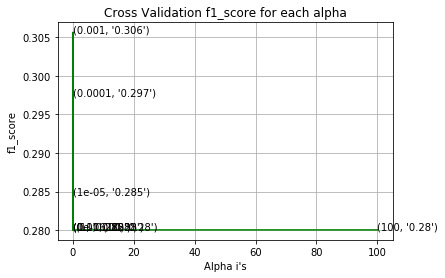

For values of best alpha =  1e-06 The train f1_score is: 0.3464353896696304
For values of best alpha =  1e-06 The cross validation f1_score is: 0.2800274536719286
For values of best alpha =  1e-06 The test f1_score is: 0.2855961243058017


In [138]:
alpha = [10 ** x for x in range(-6, 3)]
cv_f1_score_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict(cv_x_onehotCoding)
    cv_f1_score_array.append(f1_score(cv_y, sig_clf_probs,average='macro'))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("f1_score :",f1_score(cv_y, sig_clf_probs,average='macro')) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_f1_score_array,c='g')
for i, txt in enumerate(np.round(cv_f1_score_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_f1_score_array[i]))
plt.grid()
plt.title("Cross Validation f1_score for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("f1_score")
plt.show()


best_alpha = np.argmin(cv_f1_score_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train f1_score is:",f1_score(y_train, predict_y,average='macro'))
predict_y = sig_clf.predict(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation f1_score is:",f1_score(y_cv, predict_y,average='macro'))
predict_y = sig_clf.predict(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test f1_score is:",f1_score(y_test, predict_y,average='macro'))

#### Testing the model with best hyper paramters

f1 score : 0.2800274536719286
Number of mis-classified points : 0.2757396449704142
-------------------- Confusion matrix --------------------


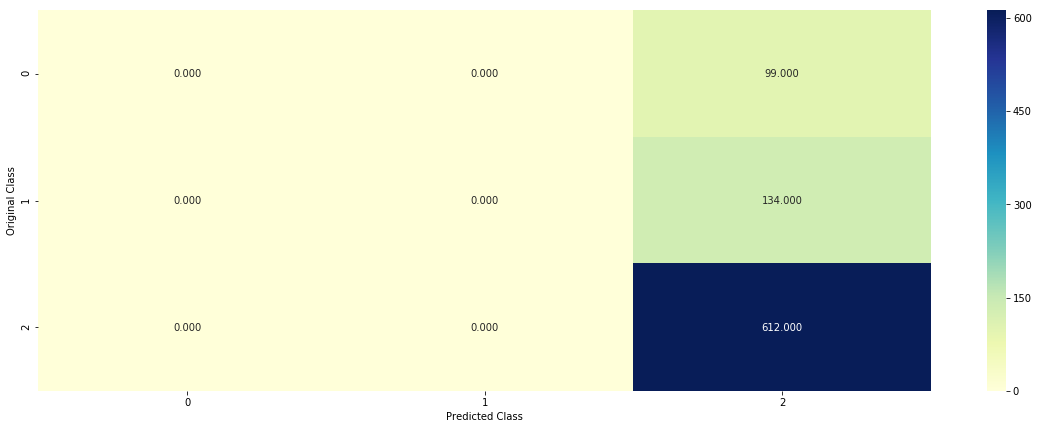

-------------------- Precision matrix (Columm Sum=1) --------------------


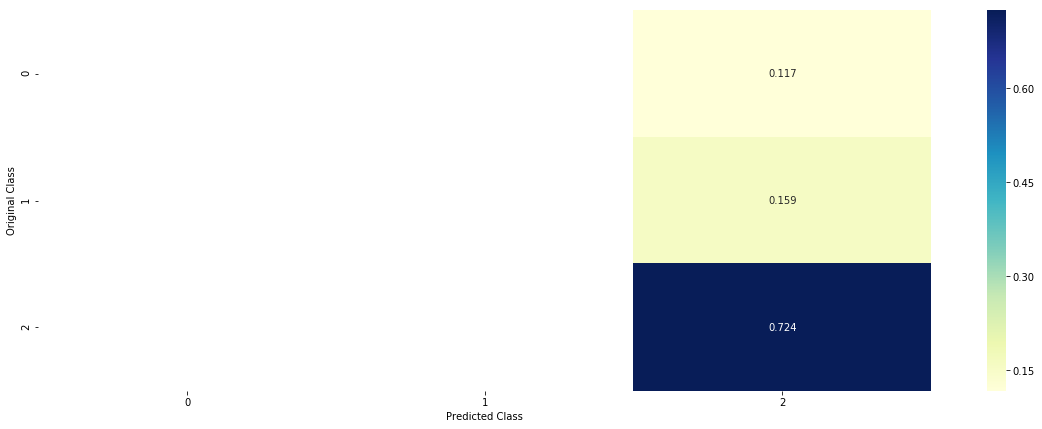

-------------------- Recall matrix (Row sum=1) --------------------


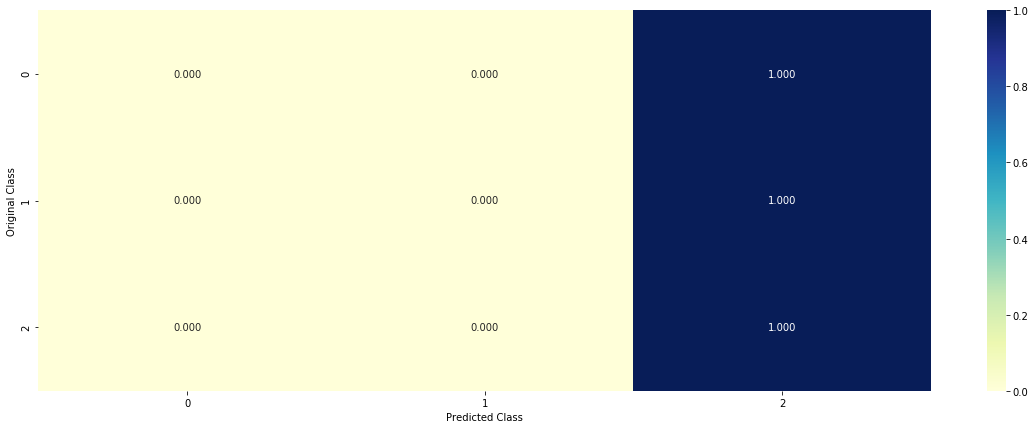

In [139]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

### with response encoding

for alpha = 1e-06
f1_score : 0.35953894554504595
for alpha = 1e-05
f1_score : 0.3389264681137473
for alpha = 0.0001
f1_score : 0.29621424382615497
for alpha = 0.001
f1_score : 0.28425280362800937
for alpha = 0.01
f1_score : 0.28485614176942253
for alpha = 0.1
f1_score : 0.28485614176942253
for alpha = 1
f1_score : 0.28485614176942253
for alpha = 10
f1_score : 0.28920665120795924
for alpha = 100
f1_score : 0.2878691290293501


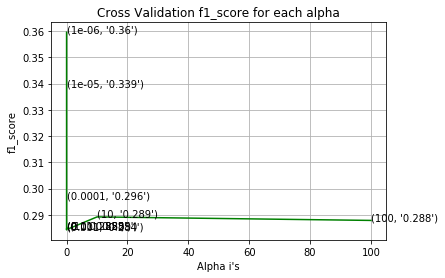

For values of best alpha =  0.001 The train f1_score is: 0.28960304176069424
For values of best alpha =  0.001 The cross validation f1_score is: 0.28425280362800937
For values of best alpha =  0.001 The test f1_score is: 0.27851361295069904


In [140]:
alpha = [10 ** x for x in range(-6, 3)]
cv_f1_score_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict(cv_x_responseCoding)
    cv_f1_score_array.append(f1_score(cv_y, sig_clf_probs,average='macro'))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("f1_score :",f1_score(cv_y, sig_clf_probs,average='macro')) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_f1_score_array,c='g')
for i, txt in enumerate(np.round(cv_f1_score_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_f1_score_array[i]))
plt.grid()
plt.title("Cross Validation f1_score for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("f1_score")
plt.show()


best_alpha = np.argmin(cv_f1_score_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train f1_score is:",f1_score(y_train, predict_y,average='macro'))
predict_y = sig_clf.predict(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation f1_score is:",f1_score(y_cv, predict_y,average='macro'))
predict_y = sig_clf.predict(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test f1_score is:",f1_score(y_test, predict_y,average='macro'))

f1 score : 0.2905598479273976
Number of mis-classified points : 0.2875739644970414
-------------------- Confusion matrix --------------------


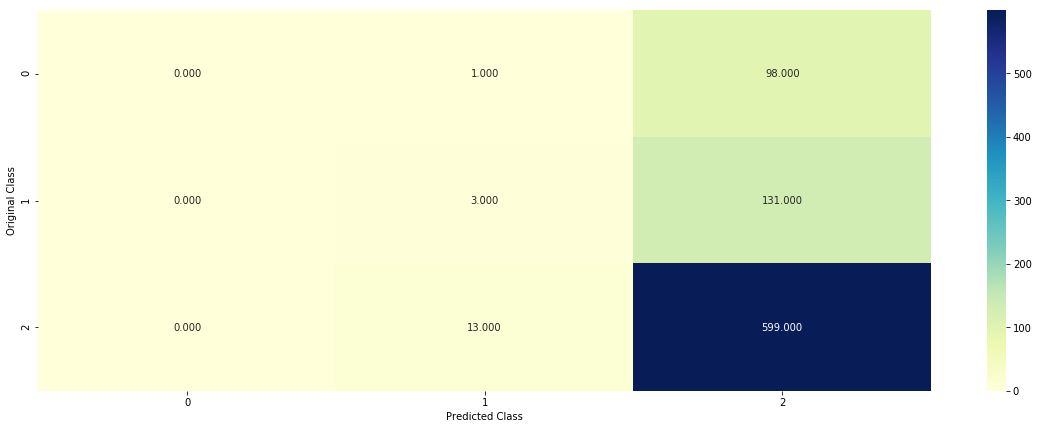

-------------------- Precision matrix (Columm Sum=1) --------------------


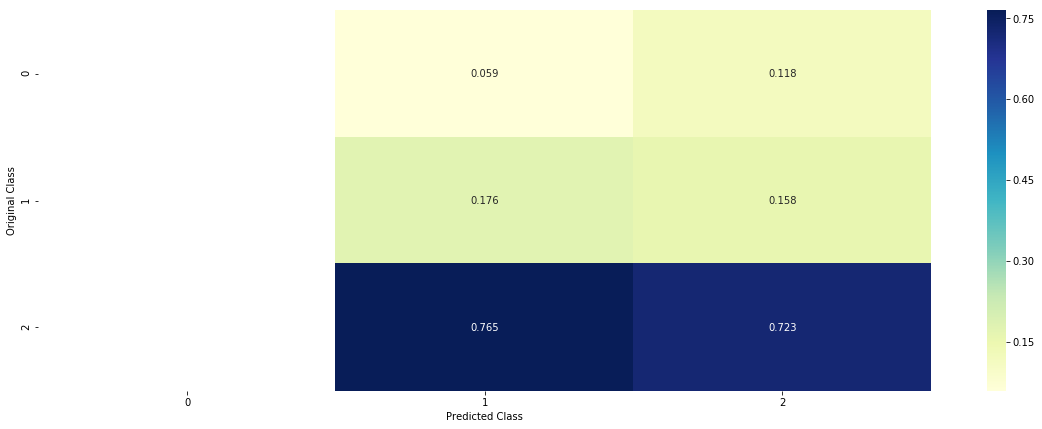

-------------------- Recall matrix (Row sum=1) --------------------


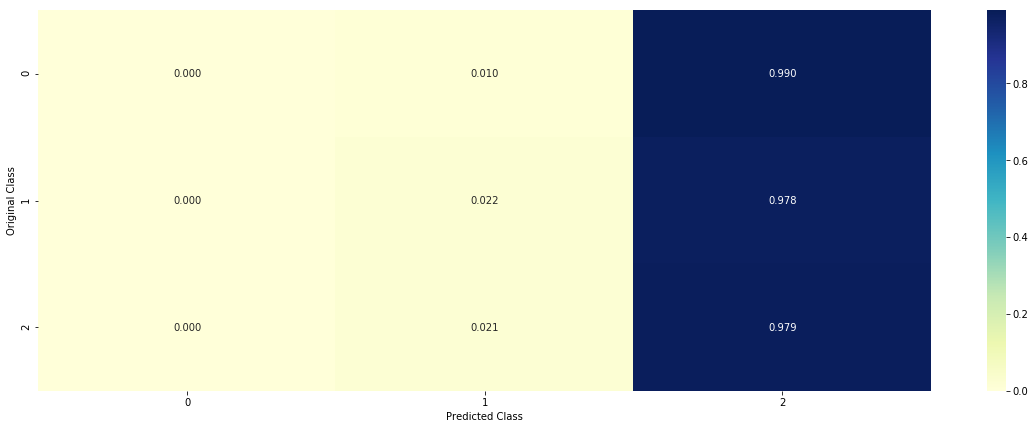

In [131]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

## Logistic regression Without Class balancing

#### Hyperparameter tuningg

for alpha = 1e-06
f1_score : 0.2797619047619047
for alpha = 1e-05
f1_score : 0.2794218857536132
for alpha = 0.0001
f1_score : 0.3222805788982259
for alpha = 0.001
f1_score : 0.3142583732057416
for alpha = 0.01
f1_score : 0.29364507871764267
for alpha = 0.1
f1_score : 0.2800274536719286
for alpha = 1
f1_score : 0.2800274536719286
for alpha = 10
f1_score : 0.2800274536719286
for alpha = 100
f1_score : 0.2800274536719286


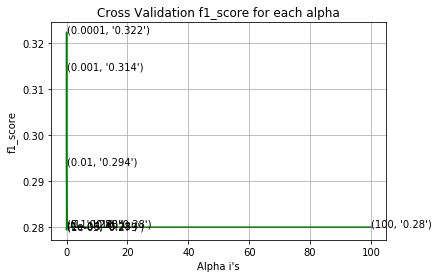

For values of best alpha =  1e-05 The train f1_score is: 0.30760368062297105
For values of best alpha =  1e-05 The cross validation f1_score is: 0.2794218857536132
For values of best alpha =  1e-05 The test f1_score is: 0.2839288986622686


In [135]:
alpha = [10 ** x for x in range(-6, 3)]
cv_f1_score_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier( alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict(cv_x_onehotCoding)
    cv_f1_score_array.append(f1_score(cv_y, sig_clf_probs,average='macro'))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("f1_score :",f1_score(cv_y, sig_clf_probs,average='macro')) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_f1_score_array,c='g')
for i, txt in enumerate(np.round(cv_f1_score_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_f1_score_array[i]))
plt.grid()
plt.title("Cross Validation f1_score for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("f1_score")
plt.show()


best_alpha = np.argmin(cv_f1_score_array)
clf = SGDClassifier( alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train f1_score is:",f1_score(y_train, predict_y,average='macro'))
predict_y = sig_clf.predict(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation f1_score is:",f1_score(y_cv, predict_y,average='macro'))
predict_y = sig_clf.predict(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test f1_score is:",f1_score(y_test, predict_y,average='macro'))

#### Testing model with best hyper parameters

f1 score : 0.2794218857536132
Number of mis-classified points : 0.27928994082840236
-------------------- Confusion matrix --------------------


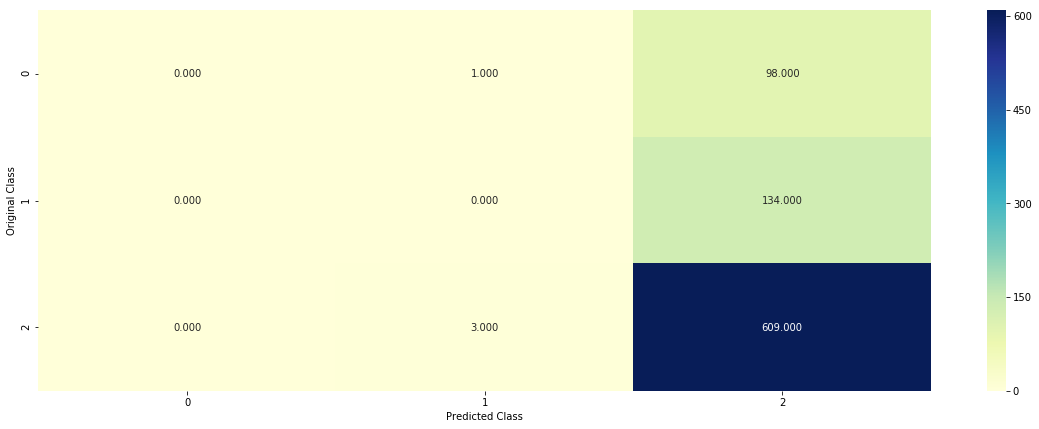

-------------------- Precision matrix (Columm Sum=1) --------------------


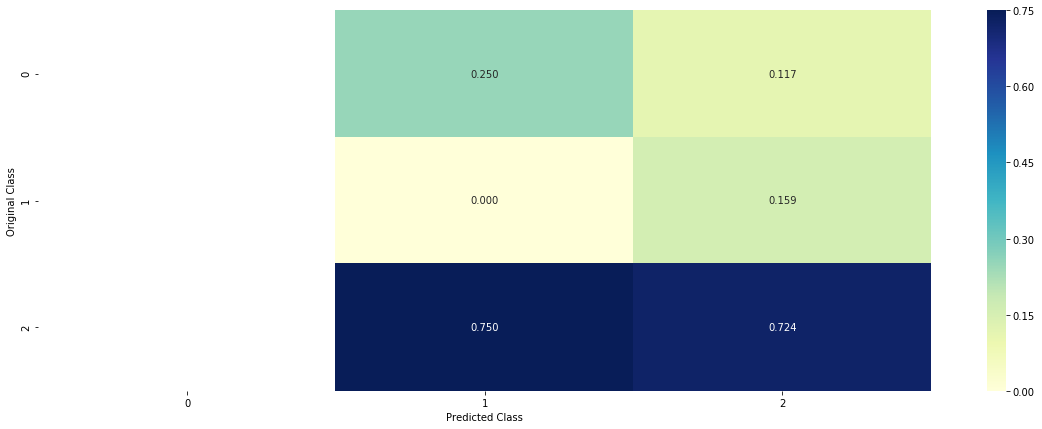

-------------------- Recall matrix (Row sum=1) --------------------


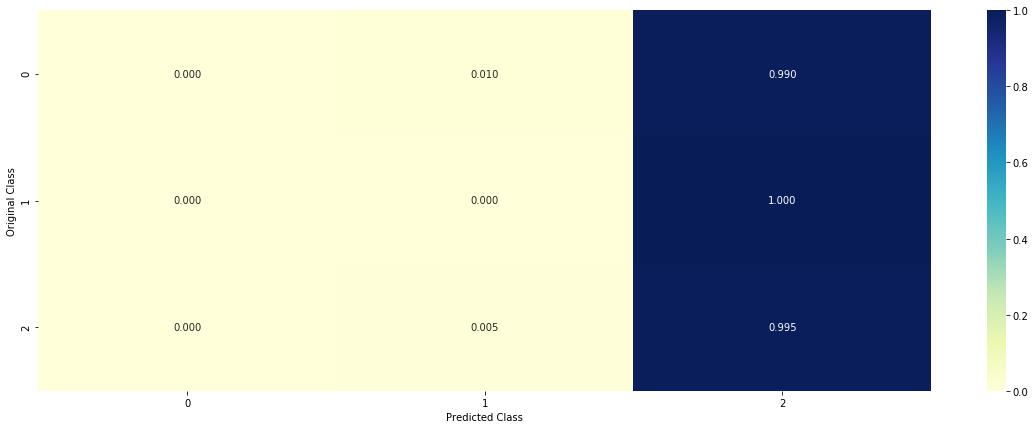

In [136]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

## Linear Support Vector Machines

#### Hyper paramter tuning

for alpha = 1e-06
f1_score : 0.2797619047619047
for alpha = 1e-05
f1_score : 0.2794218857536132
for alpha = 0.0001
f1_score : 0.3222805788982259
for alpha = 0.001
f1_score : 0.3142583732057416
for alpha = 0.01
f1_score : 0.29364507871764267
for alpha = 0.1
f1_score : 0.2800274536719286
for alpha = 1
f1_score : 0.2800274536719286
for alpha = 10
f1_score : 0.2800274536719286
for alpha = 100
f1_score : 0.2800274536719286


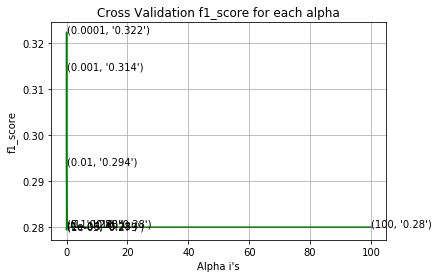

For values of best alpha =  1e-05 The train f1_score is: 0.30760368062297105
For values of best alpha =  1e-05 The cross validation f1_score is: 0.2794218857536132
For values of best alpha =  1e-05 The test f1_score is: 0.2839288986622686


In [137]:
alpha = [10 ** x for x in range(-6, 3)]
cv_f1_score_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier( alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict(cv_x_onehotCoding)
    cv_f1_score_array.append(f1_score(cv_y, sig_clf_probs,average='macro'))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("f1_score :",f1_score(cv_y, sig_clf_probs,average='macro')) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_f1_score_array,c='g')
for i, txt in enumerate(np.round(cv_f1_score_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_f1_score_array[i]))
plt.grid()
plt.title("Cross Validation f1_score for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("f1_score")
plt.show()


best_alpha = np.argmin(cv_f1_score_array)
clf = SGDClassifier( alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train f1_score is:",f1_score(y_train, predict_y,average='macro'))
predict_y = sig_clf.predict(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation f1_score is:",f1_score(y_cv, predict_y,average='macro'))
predict_y = sig_clf.predict(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test f1_score is:",f1_score(y_test, predict_y,average='macro'))

#### Testing model with best hyper parameters

f1 score : 0.31914442668683013
Number of mis-classified points : 0.2828402366863905
-------------------- Confusion matrix --------------------


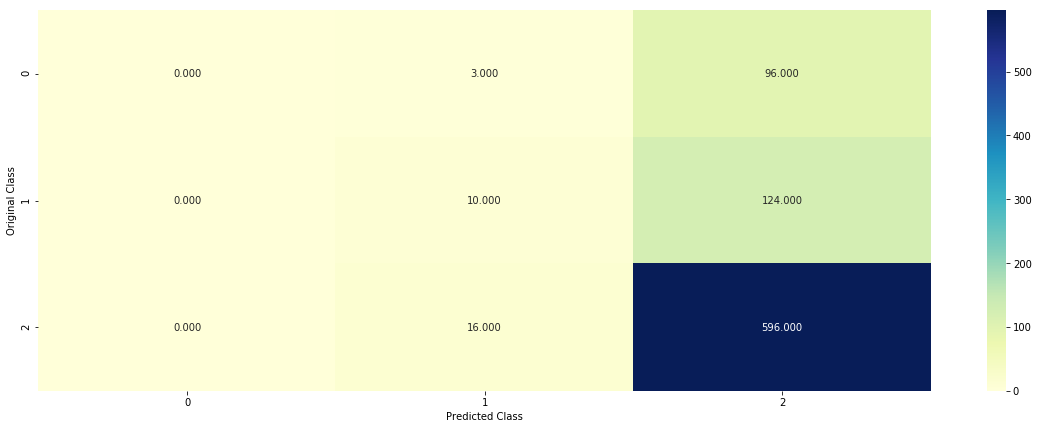

-------------------- Precision matrix (Columm Sum=1) --------------------


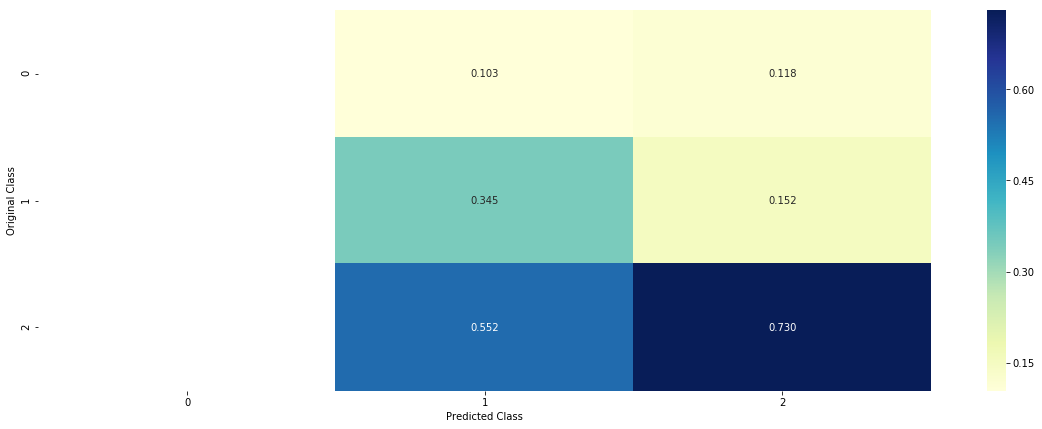

-------------------- Recall matrix (Row sum=1) --------------------


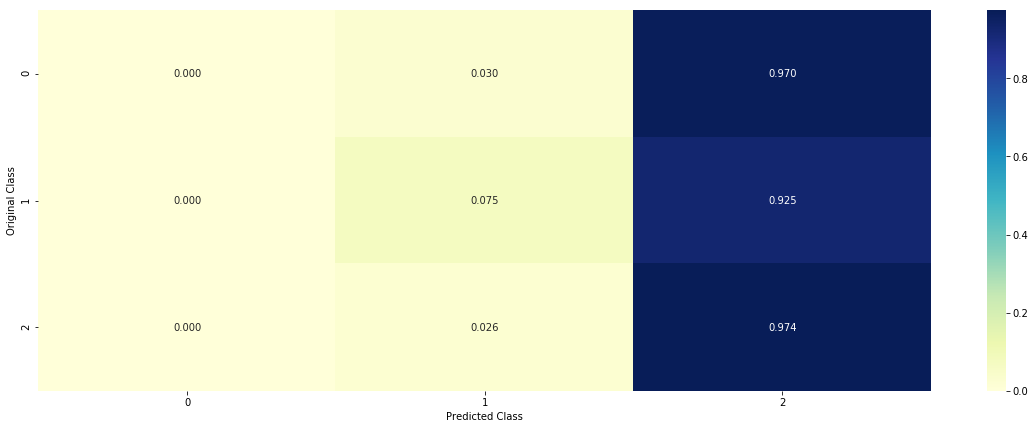

In [141]:
# clf = SVC(C=alpha[best_alpha],kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

## Random Forest Classifier with one hot encoding

In [142]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_f1_score_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict(cv_x_onehotCoding)
        cv_f1_score_array.append(f1_score(cv_y, sig_clf_probs,average='macro'))
        print("f1_score :",f1_score(cv_y, sig_clf_probs,average='macro')) 

'''fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmax(cv_f1_score_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train f1_score is:",f1_score(y_train, predict_y,average='macro'))
predict_y = sig_clf.predict(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation f1_score is:",f1_score(y_cv, predict_y,average='macro'))
predict_y = sig_clf.predict(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test f1_score is:",f1_score(y_test, predict_y,average='macro'))

for n_estimators = 100 and max depth =  5
f1_score : 0.31703361669128727
for n_estimators = 100 and max depth =  10
f1_score : 0.328929125758424
for n_estimators = 200 and max depth =  5
f1_score : 0.3222612633715936
for n_estimators = 200 and max depth =  10
f1_score : 0.3322216781236876
for n_estimators = 500 and max depth =  5
f1_score : 0.32796934237087855
for n_estimators = 500 and max depth =  10
f1_score : 0.3332330323751749
for n_estimators = 1000 and max depth =  5
f1_score : 0.32527155040697836
for n_estimators = 1000 and max depth =  10
f1_score : 0.3337965537953425
for n_estimators = 2000 and max depth =  5
f1_score : 0.3361388391719087
for n_estimators = 2000 and max depth =  10
f1_score : 0.3317756120947611
For values of best estimator =  2000 The train f1_score is: 0.42576513052562664
For values of best estimator =  2000 The cross validation f1_score is: 0.3361388391719087
For values of best estimator =  2000 The test f1_score is: 0.34019343179410483


#### Testing model with best hyper parameters (One Hot Encoding)

f1 score : 0.3361388391719087
Number of mis-classified points : 0.28875739644970416
-------------------- Confusion matrix --------------------


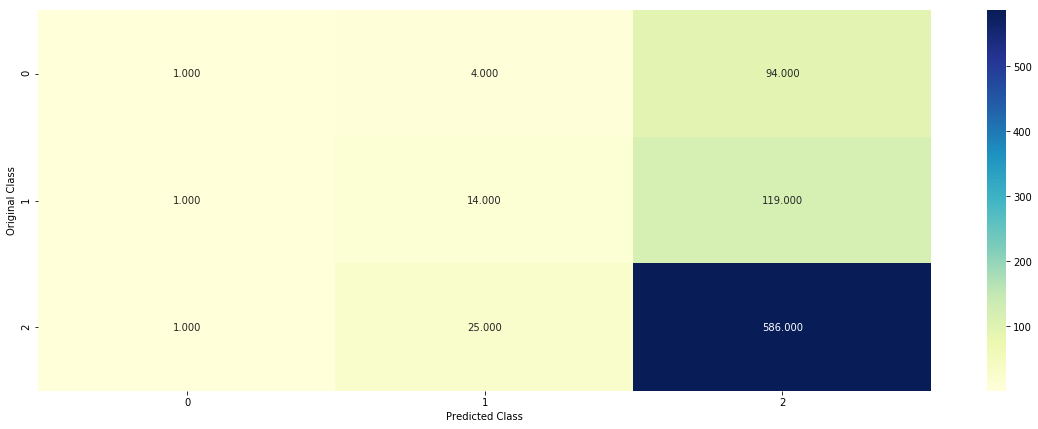

-------------------- Precision matrix (Columm Sum=1) --------------------


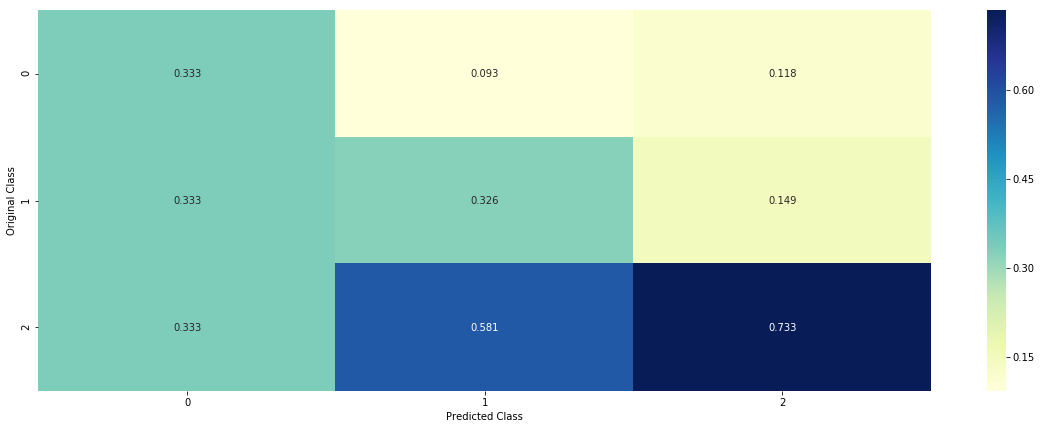

-------------------- Recall matrix (Row sum=1) --------------------


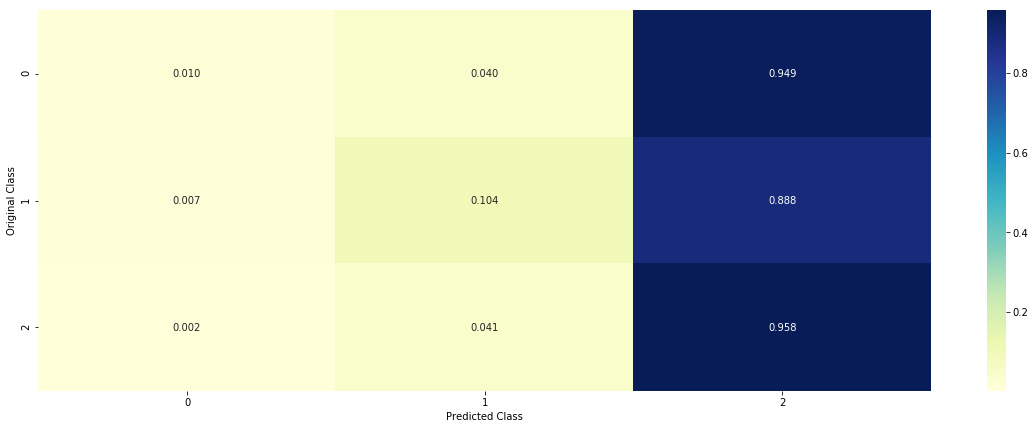

In [143]:
clf = RandomForestClassifier(n_estimators=2000, criterion='gini', max_depth=5, random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

## Hyper paramter tuning (With Response Coding)

In [165]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_f1_score_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict(cv_x_responseCoding)
        cv_f1_score_array.append(f1_score(cv_y, sig_clf_probs,average='macro'))
        print("f1_score :",f1_score(cv_y, sig_clf_probs,average='macro')) 

'''fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmax(cv_f1_score_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict(train_x_responseCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train f1_score is:",f1_score(y_train, predict_y,average='macro'))
predict_y = sig_clf.predict(cv_x_responseCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation f1_score is:",f1_score(y_cv, predict_y,average='macro'))
predict_y1 = sig_clf.predict(test_x_responseCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test f1_score is:",f1_score(y_test, predict_y1,average='macro'))

for n_estimators = 100 and max depth =  5
f1_score : 0.34578326985111496
for n_estimators = 100 and max depth =  10
f1_score : 0.3582010911726532
for n_estimators = 200 and max depth =  5
f1_score : 0.3470981903844095
for n_estimators = 200 and max depth =  10
f1_score : 0.36061875112723274
for n_estimators = 500 and max depth =  5
f1_score : 0.34729082593489374
for n_estimators = 500 and max depth =  10
f1_score : 0.36131582880808893
for n_estimators = 1000 and max depth =  5
f1_score : 0.3512973245835436
for n_estimators = 1000 and max depth =  10
f1_score : 0.3616568807938691
for n_estimators = 2000 and max depth =  5
f1_score : 0.3512973245835436
for n_estimators = 2000 and max depth =  10
f1_score : 0.36096019647903743
For values of best estimator =  1000 The train f1_score is: 0.5262945452128246
For values of best estimator =  1000 The cross validation f1_score is: 0.3616568807938691
For values of best estimator =  1000 The test f1_score is: 0.3582415252291759


## Testing model with best hyper parameters (Response Coding)

f1 score : 0.3616568807938691
Number of mis-classified points : 0.27928994082840236
-------------------- Confusion matrix --------------------


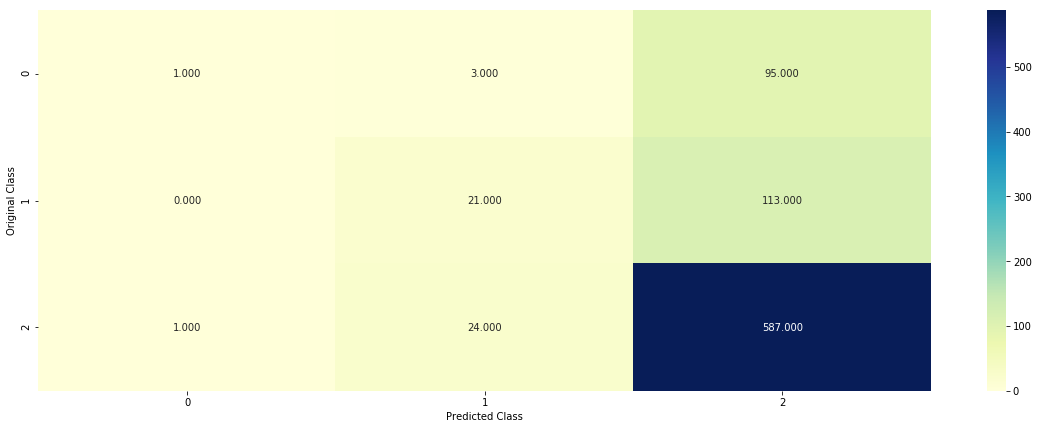

-------------------- Precision matrix (Columm Sum=1) --------------------


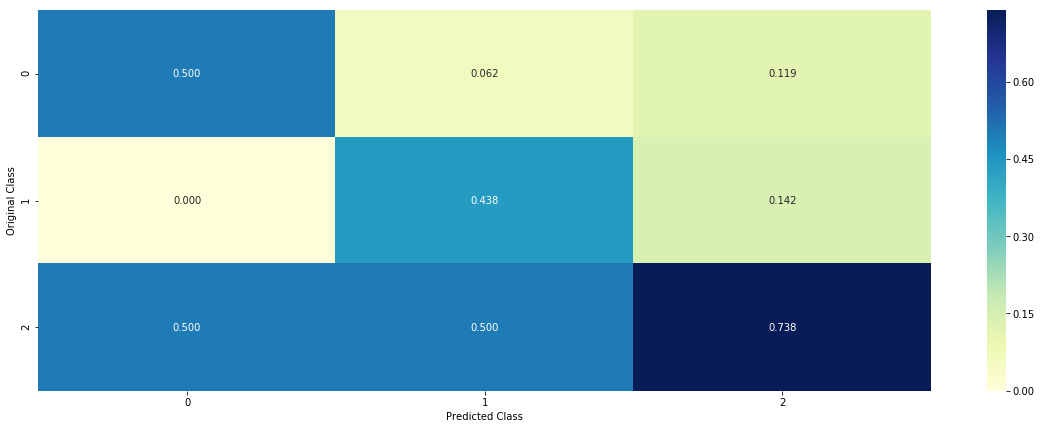

-------------------- Recall matrix (Row sum=1) --------------------


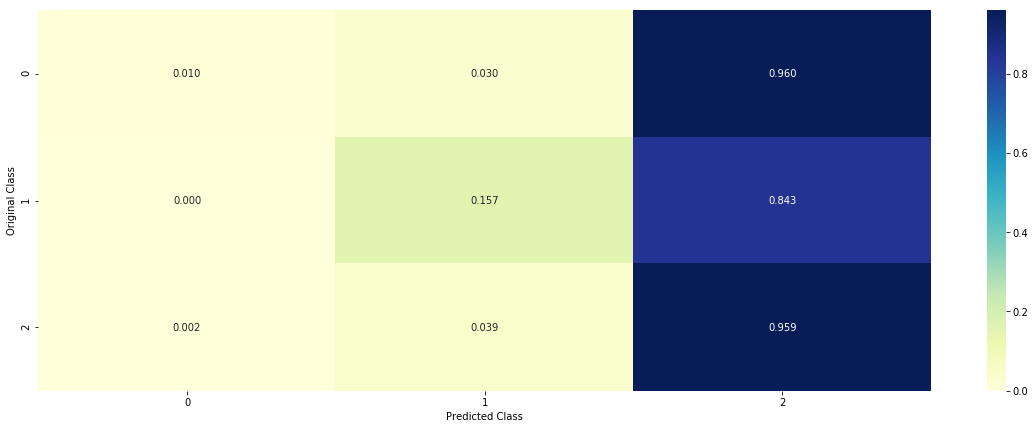

In [171]:
sig_clf = RandomForestClassifier(max_depth=10, n_estimators=1000, criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

In [178]:
clf = RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=10, random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [182]:
predict_y1 = clf.predict(data_test_x_responseCoding)

In [183]:
type(predict_y1)

numpy.ndarray

In [184]:

print(predict_y1)
new_series = pd.Series(predict_y1)
new_series.value_counts()

[2 2 2 ... 2 2 2]


2    2923
1       1
dtype: int64

In [185]:
predictions = pd.DataFrame(new_series, columns=['sentiment'])
predictions.to_csv("sentiment_analysis_response.csv", index=False)

## Stack the models

In [188]:
clf1 = SGDClassifier(alpha=1e-06, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf1.fit(train_x_onehotCoding, train_y)

clf2 = SGDClassifier(alpha=1e-05, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf2.fit(train_x_onehotCoding, train_y)


clf3 = MultinomialNB(alpha=1e-05)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf3.fit(train_x_onehotCoding, train_y)

clf4 = RandomForestClassifier(max_depth=10, n_estimators=1000, criterion='gini', max_features='auto',random_state=42)
clf4.fit(train_x_onehotCoding, train_y)
sig_clf4 = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf4.fit(train_x_onehotCoding, train_y)

clf5 = KNeighborsClassifier(n_neighbors=15)
clf5.fit(train_x_responseCoding, train_y)
sig_clf5 = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf5.fit(train_x_responseCoding, train_y)

print("f1_score :",f1_score(cv_y, sig_clf_probs,average='macro'))


print("Logistic Regression :  f1_score: %0.2f" % (f1_score(cv_y, sig_clf1.predict(cv_x_onehotCoding),average='macro')))

print("Support vector machines :f1_score: %0.2f" % (f1_score(cv_y, sig_clf2.predict(cv_x_onehotCoding),average='macro')))

print("Naive Bayes : f1_score: %0.2f" % (f1_score(cv_y, sig_clf3.predict(cv_x_onehotCoding),average='macro')))

print("Random forest : f1_score: %0.2f" % (f1_score(cv_y, sig_clf3.predict(cv_x_onehotCoding),average='macro')))

print("KNN : f1_score: %0.2f" % (f1_score(cv_y, sig_clf3.predict(cv_x_onehotCoding),average='macro')))

print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3,sig_clf4,sig_clf5], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, f1_score(cv_y, sclf.predict(cv_x_onehotCoding),average='macro')))
    log_error =f1_score(cv_y, sclf.predict(cv_x_onehotCoding),average='macro')
    if best_alpha > log_error:
        best_alpha = log_error

f1_score : 0.36096019647903743
Logistic Regression :  f1_score: 0.33
Support vector machines :f1_score: 0.33
Naive Bayes : f1_score: 0.33
Random forest : f1_score: 0.33
KNN : f1_score: 0.33
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 0.280
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 0.280
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 0.320
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 0.374
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 0.424
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 0.438


Log loss (train) on the stacking classifier : 0.4292674642596297
Log loss (CV) on the stacking classifier : 0.4292674642596297
Log loss (test) on the stacking classifier : 0.4292674642596297
Number of missclassified point : 0.3541666666666667
-------------------- Confusion matrix --------------------


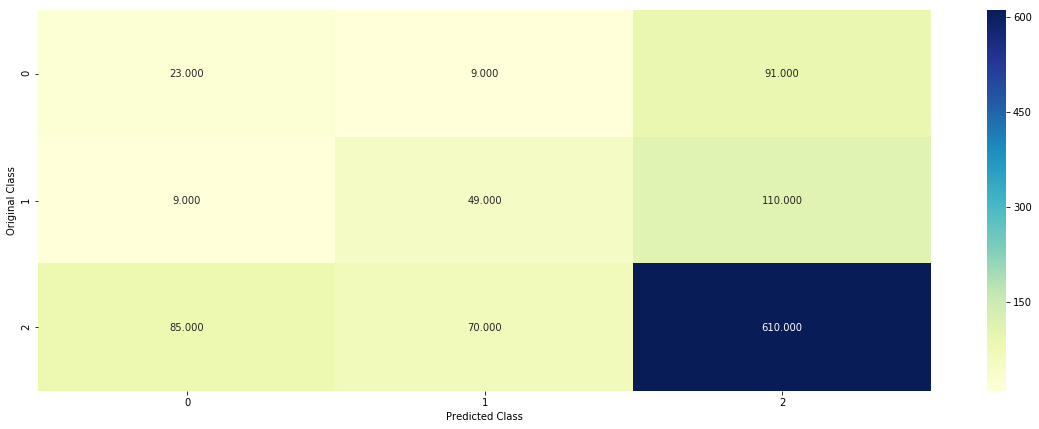

-------------------- Precision matrix (Columm Sum=1) --------------------


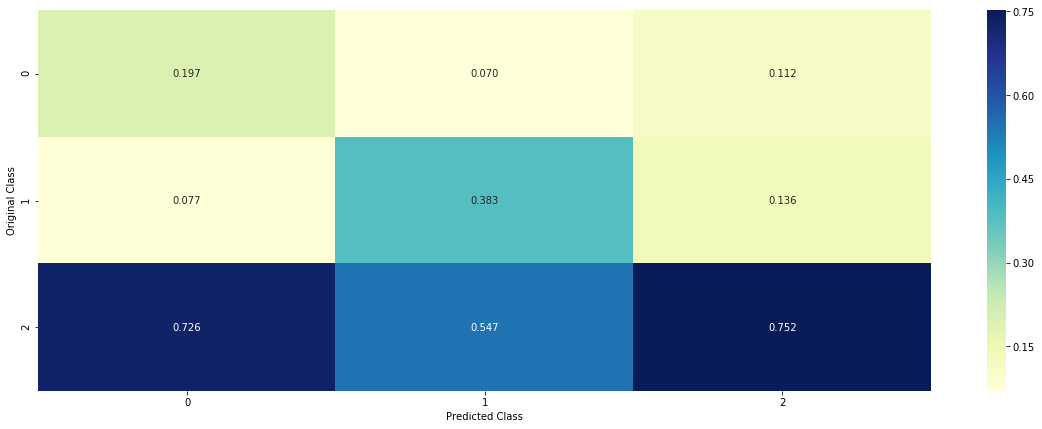

-------------------- Recall matrix (Row sum=1) --------------------


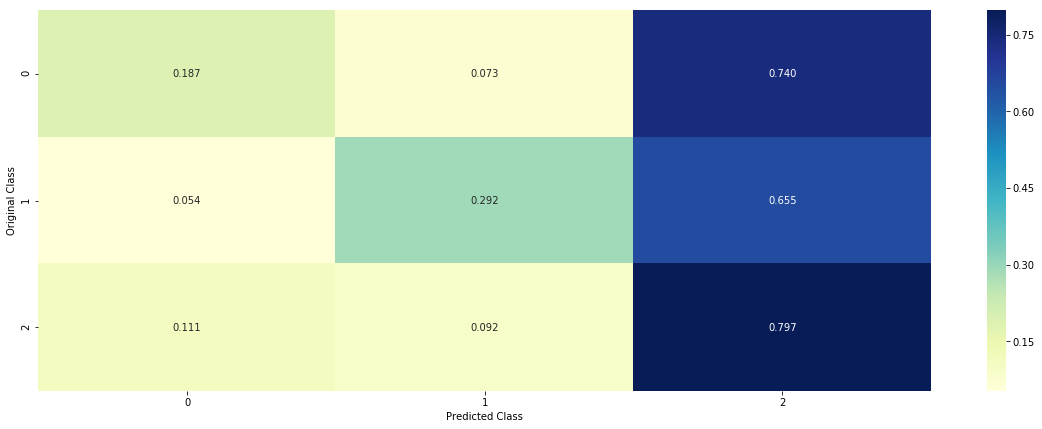

In [189]:
lr = LogisticRegression(C=19)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3,sig_clf4,sig_clf5], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = f1_score(cv_y, sclf.predict(cv_x_onehotCoding),average='macro')
print("Log loss (train) on the stacking classifier :",log_error)

log_error = f1_score(cv_y, sclf.predict(cv_x_onehotCoding),average='macro')
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = f1_score(cv_y, sclf.predict(cv_x_onehotCoding),average='macro')
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

In [194]:
predict_y1 = sclf.predict(data_test_x_onehotCoding)
print(predict_y1)
new_series = pd.Series(predict_y1)
new_series.value_counts()

[2 2 2 ... 2 2 2]


2    2517
1     281
0     126
dtype: int64

In [198]:
predictions = pd.DataFrame(new_series, columns=['sentiment'])
predictions.to_csv("sentiment_analysis_submission.csv", index=False)